# Optimizer test

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [6]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [7]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view(scaled_data, window_size, axis=0).transpose(0,2,1)[:-1]
    output_data = scaled_data[window_size:,1]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(split*len(data))
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [8]:
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
hub = keras.losses.Huber()

def eval_model(model, history, type, loss='mae', optimizer='AdamW'):
    y_pred = model.predict(X_test)
    res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
    sns.lineplot(res, dashes=False)
    plt.show()
    
    pd.DataFrame(history.history).plot()
    plt.show()

    return {
        'type': type,
        'best_val_loss': min(history.history['val_loss']),
        'loss_method': loss,
        'optimizer': optimizer,
        'mae': mae(y_test, y_pred).numpy(),
        'mse': mse(y_test, y_pred).numpy(),
        'huber': hub(y_test, y_pred).numpy(),
    }

def res_to_table(result):
    return pd.DataFrame.from_dict(result, orient='index').T

In [29]:
results = []

In [10]:
scaler = MinMaxScaler((-1,1))
data = np.array(df)
((X_train, y_train), (X_test, y_test)) = prepare_data(data, scaler)

In [30]:
def simpleRNN(loss, loss_name):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.SimpleRNN(50),
        keras.layers.Dense(1),
    ])
    
    model.summary()
    
    epochs = 300
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss=loss,
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'SimpleRNN_1layer', loss=loss_name)
    display(res_to_table(res))
    results.append(res)


In [31]:
def lstm(loss, loss_name):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.LSTM(50),
        keras.layers.Dense(1),
    ])
    
    model.summary()
    
    epochs = 800
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss=loss,
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'LSTM_1layer', loss=loss_name)
    display(res_to_table(res))
    results.append(res)
    

In [32]:
def gru(loss, loss_name):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.GRU(50, return_sequences=True),
        keras.layers.GRU(50),
        keras.layers.Dense(1),
    ])
    
    epochs = 600
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss=loss,
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'GRU_2layer', loss=loss_name)
    display(res_to_table(res))
    results.append(res)

## Testiranje

Testing model simpleRNN with loss mae:
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 50)                2850      
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 21ms/step - loss: 0.1322 - val_loss: 0.0723 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 18ms/step - loss: 0.0284 - val_loss: 0.0545 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0176 - val_loss: 0.0468 - lr: 0.0010
Epoch 4/300
25/25 [==================

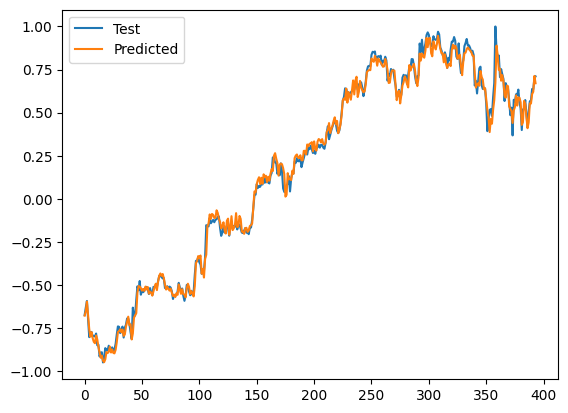

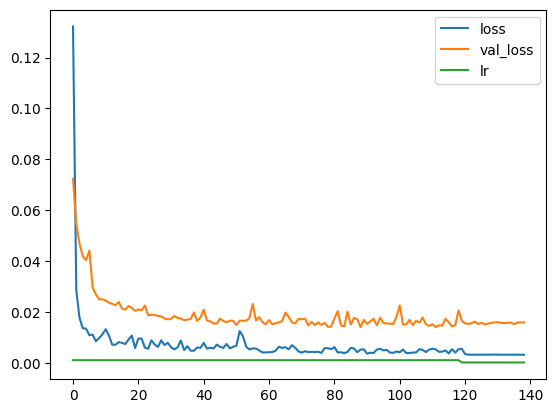

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,SimpleRNN_1layer,0.014008,mae,AdamW,0.028586,0.001649,0.000824


--------------


Testing model lstm with loss mae:
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                11400     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 16ms/step - loss: 0.1375 - val_loss: 0.1092 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0306 - val_loss: 0.0544 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 0.0678 - lr: 0.0010
Epoch 4/800
25/25 [======

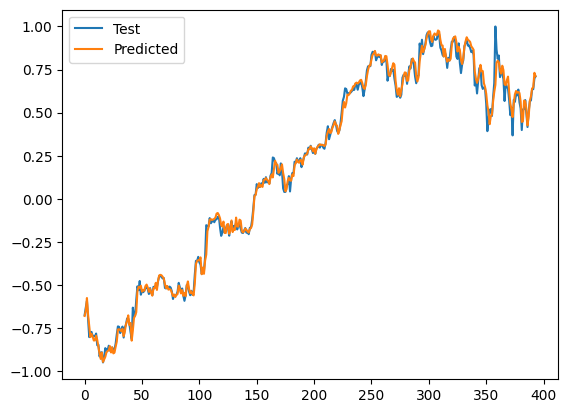

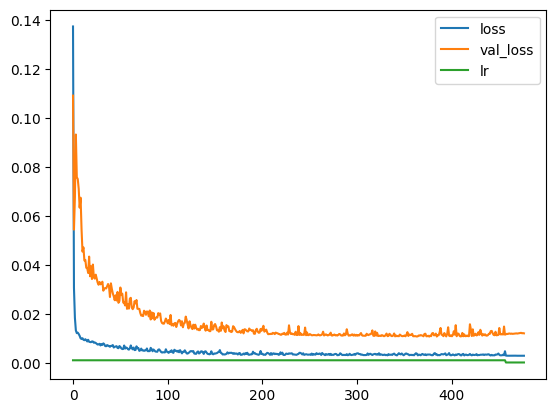

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,LSTM_1layer,0.01068,mae,AdamW,0.02371,0.001418,0.000709


--------------


Testing model gru with loss mae:
Epoch 1/600
25/25 [==============================] - 3s 25ms/step - loss: 0.1214 - val_loss: 0.0847 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.0361 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0378 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 9ms/step - loss: 0.0091 - val_loss: 0.0296 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 9ms/step - loss: 0.0091 - val_loss: 0.0342 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0416 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0409 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0495 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 

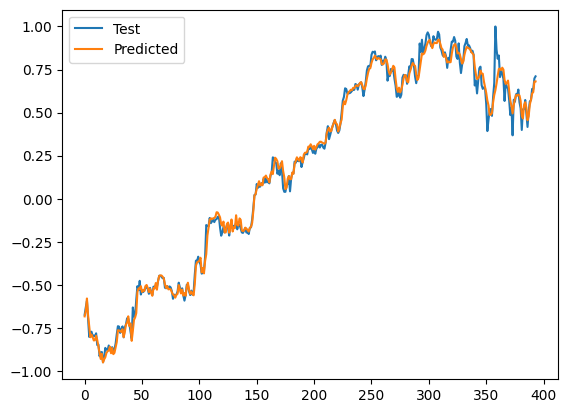

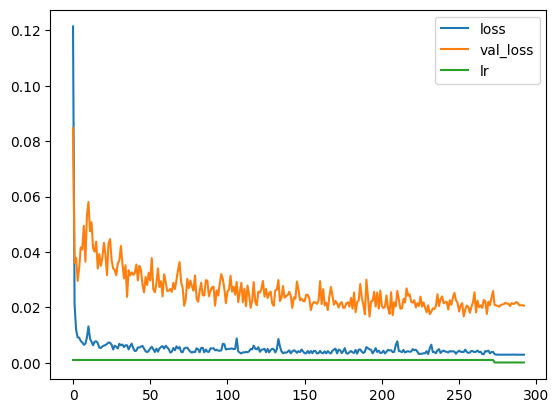

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,GRU_2layer,0.016688,mae,AdamW,0.026867,0.001788,0.000894


--------------


Testing model simpleRNN with loss msle:
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 50)                2850      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 21ms/step - loss: 2.0519e-04 - val_loss: 0.1144 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 15ms/step - loss: 2.0519e-04 - val_loss: 0.1144 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 18ms/step - loss: 2.0519e-04 - val_loss: 0.1144 - lr: 0.0010
Epoch 4

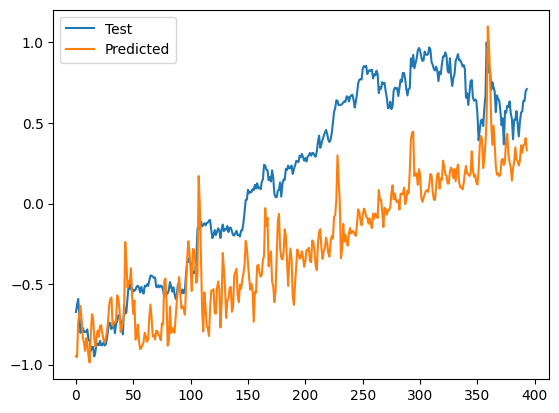

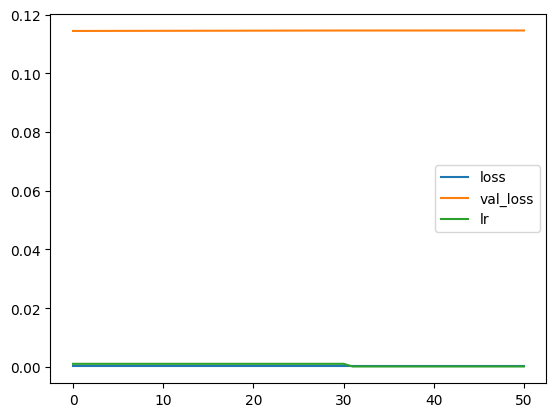

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,SimpleRNN_1layer,0.114404,msle,AdamW,0.454533,0.277444,0.138722


--------------


Testing model lstm with loss msle:
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                11400     
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 17ms/step - loss: 2.0519e-04 - val_loss: 0.1666 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 2.0519e-04 - val_loss: 0.1666 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 2.0519e-04 - val_loss: 0.1666 - lr: 0.0010
Epoch 4/800


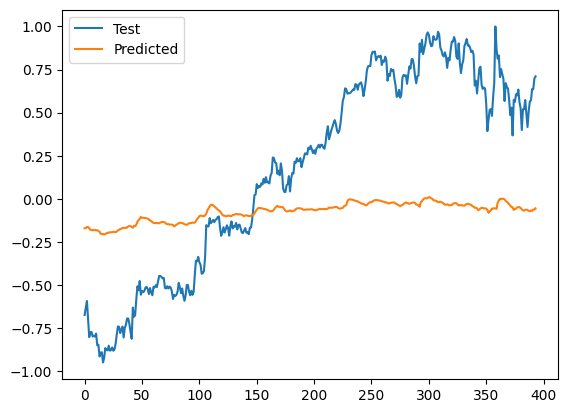

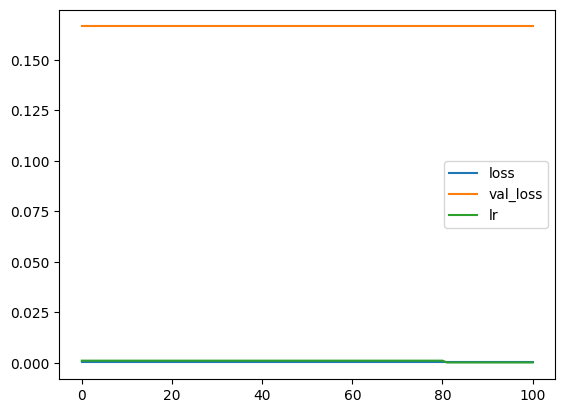

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,LSTM_1layer,0.16659,msle,AdamW,0.515365,0.336773,0.168382


--------------


Testing model gru with loss msle:
Epoch 1/600
25/25 [==============================] - 3s 24ms/step - loss: 2.8222e-04 - val_loss: 0.1025 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 2.0519e-04 - val_loss: 0.0990 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 2.0519e-04 - val_loss: 0.0987 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 6ms/step - loss: 2.0519e-04 - val_loss: 0.0987 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 7ms/step - loss: 2.0519e-04 - val_loss: 0.0987 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 6ms/step - loss: 2.0519e-04 - val_loss: 0.0988 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 6ms/step - loss: 2.0519e-04 - val_loss: 0.0988 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 7ms/step - loss: 2.0519e-04 - val_loss: 0.0988 - lr: 0.0010
Epoch 9/600
25/25 [=

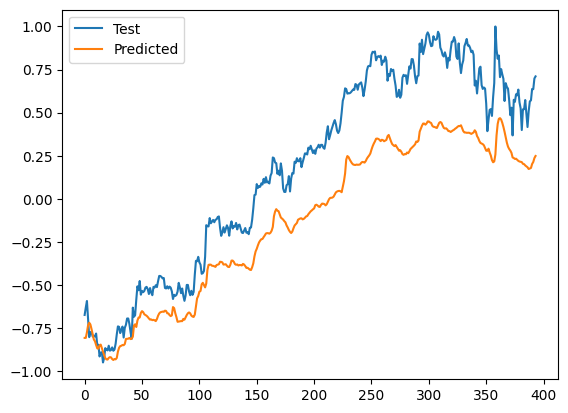

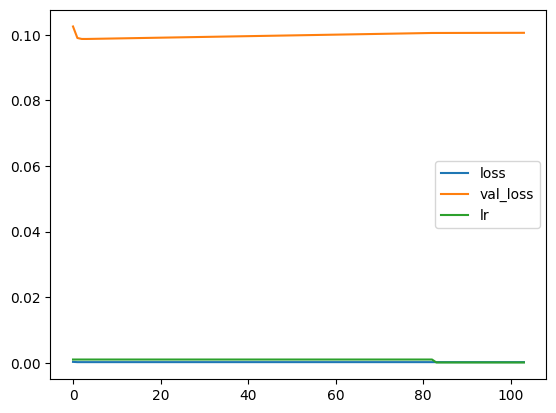

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,GRU_2layer,0.098713,msle,AdamW,0.297602,0.108821,0.05441


--------------


Testing model simpleRNN with loss huber:
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 50)                2850      
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 25ms/step - loss: 0.0458 - val_loss: 0.0287 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0124 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0167 - lr: 0.0010
Epoch 4/300
25/25 

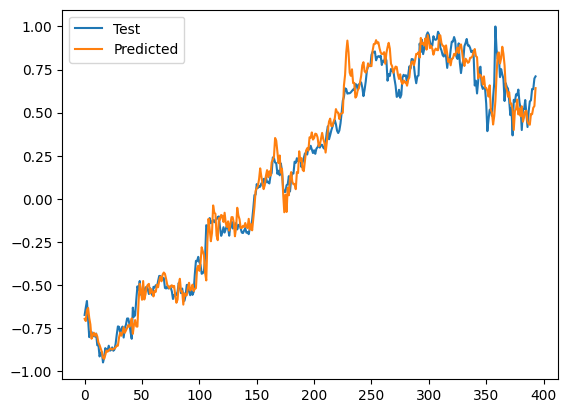

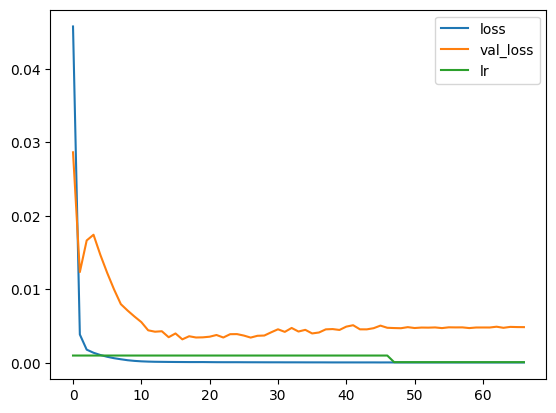

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,SimpleRNN_1layer,0.003203,huber,AdamW,0.062201,0.006915,0.003457


--------------


Testing model lstm with loss huber:
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                11400     
                                                                 
 dense_29 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 17ms/step - loss: 0.0193 - val_loss: 0.0114 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 6.2607e-04 - val_loss: 0.0151 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 1.9215e-04 - val_loss: 0.0138 - lr: 0.0010
Epoch 4/800
25/

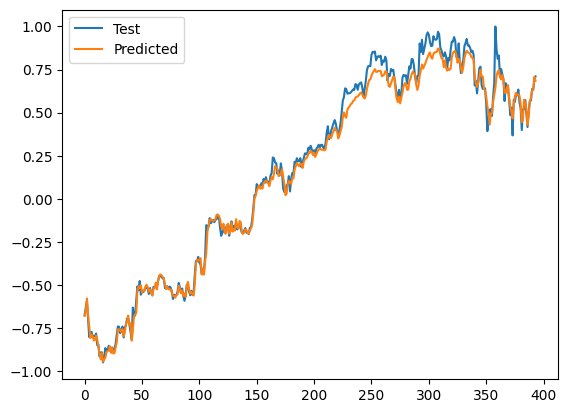

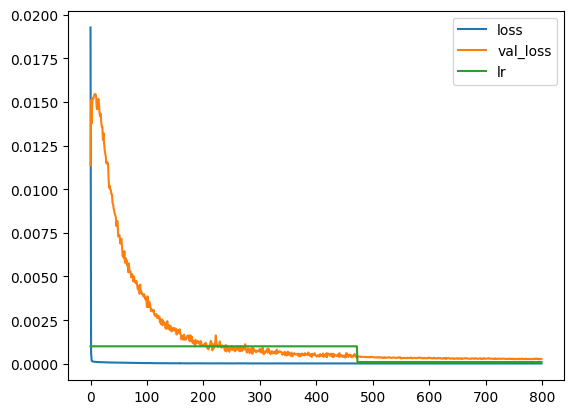

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,LSTM_1layer,0.000252,huber,AdamW,0.038409,0.002908,0.001454


--------------


Testing model gru with loss huber:
Epoch 1/600
25/25 [==============================] - 3s 26ms/step - loss: 0.0307 - val_loss: 0.0013 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0023 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 2.1655e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 7ms/step - loss: 1.4447e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 7ms/step - loss: 1.2742e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 7ms/step - loss: 1.1626e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 7ms/step - loss: 1.0651e-04 - val_loss: 9.0577e-04 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 7ms/step - loss: 1.0017e-04 - val_loss: 9.2652e-04 - lr: 0.0010
Epoch 9/600
25/25 [

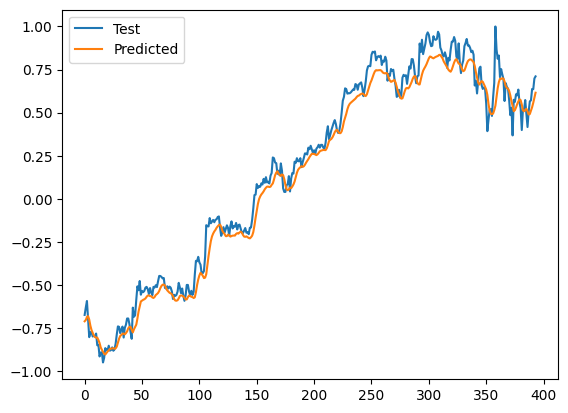

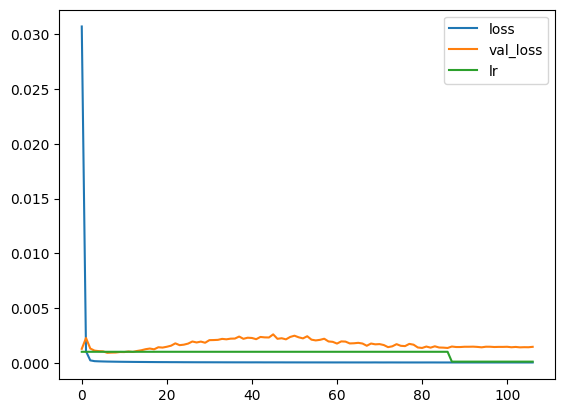

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,GRU_2layer,0.000906,huber,AdamW,0.064736,0.00694,0.00347


--------------




In [34]:
losses = [
    'mae',
    'msle',
    'huber'
]
for loss in losses:
    for model_fn in [simpleRNN, lstm, gru]:
        print(f'Testing model {model_fn.__name__} with loss {loss}:')
        model_fn(loss, loss)
        print('--------------\n\n')

### Custom Loss Function

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 50)                2850      
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 22ms/step - loss: 0.3547 - val_loss: 1.7594 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0914 - val_loss: 0.9932 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0390 - val_loss: 0.4960 - lr: 0.0010
Epoch 4/300
25/25 [==============================] - 0s 16ms/step - loss: 0.

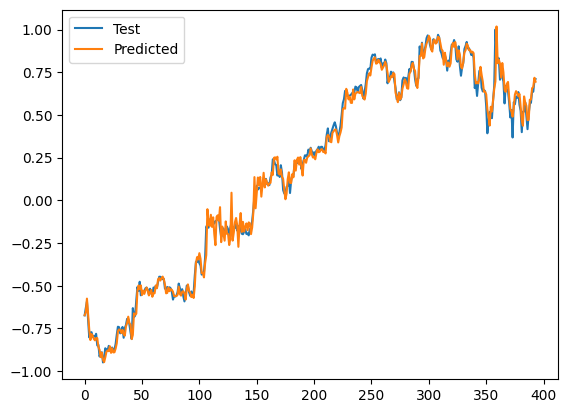

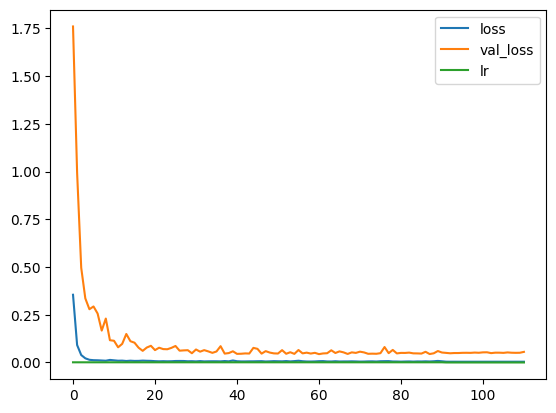

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,SimpleRNN_1layer,0.043801,custom,AdamW,0.031408,0.001963,0.000981


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                11400     
                                                                 
 dense_32 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 18ms/step - loss: 2.8035 - val_loss: 2.4677 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 5ms/step - loss: 0.1207 - val_loss: 1.5999 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0379 - val_loss: 1.4279 - lr: 0.0010
Epoch 4/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0

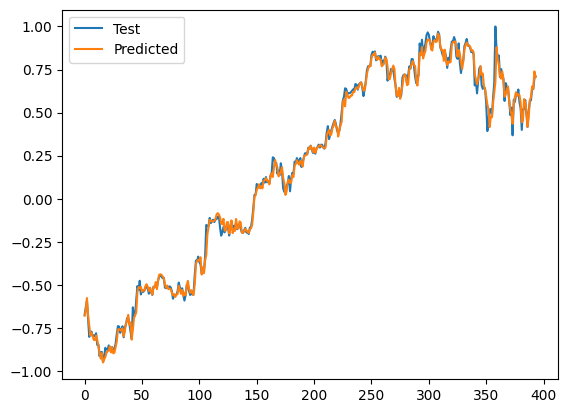

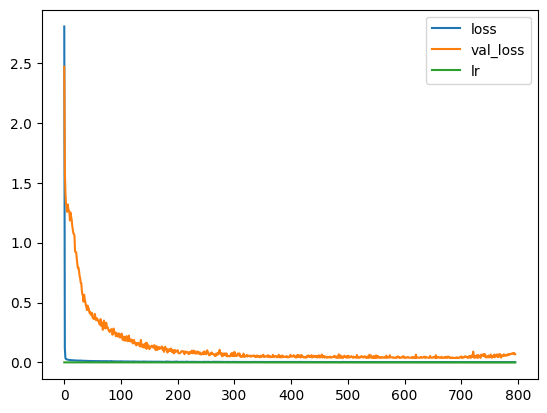

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,LSTM_1layer,0.037127,custom,AdamW,0.021621,0.001179,0.00059


Epoch 1/600
25/25 [==============================] - 3s 25ms/step - loss: 6.1191 - val_loss: 1.0628 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.2786 - val_loss: 1.8780 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0751 - val_loss: 0.6616 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0386 - val_loss: 0.3595 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0256 - val_loss: 0.2153 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.1688 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.1516 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0170 - val_loss: 0.1496 - lr: 0.0010
Epoch 9/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.1524 - lr

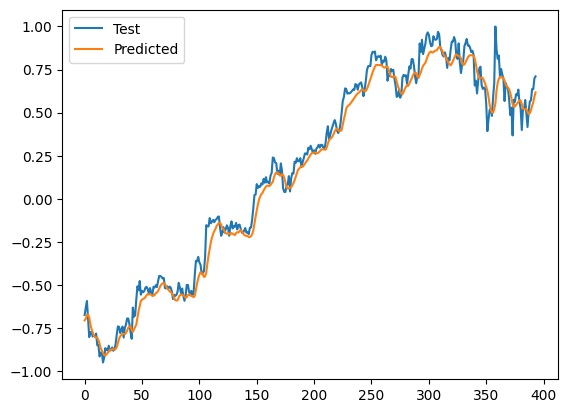

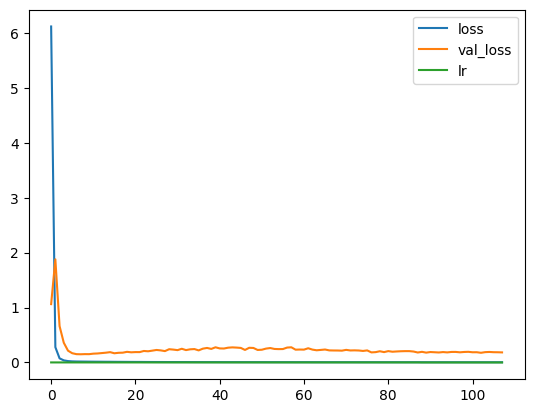

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,GRU_2layer,0.149629,custom,AdamW,0.057113,0.005661,0.002831


In [35]:
# Kako je loss sa mse obicno previse mali mozda preciznost krene da pravi problem
# Zbog toga se vrsi mnozenje rezultata sa 100
def custom_mse(y_true, y_pred):
    mse = (y_true - y_pred)**2
    return mse*100

for model_fn in [simpleRNN, lstm, gru]:
    model_fn(custom_mse, 'custom')

## Rezultati

In [36]:
res = pd.DataFrame(results)
res

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,SimpleRNN_1layer,0.014008,mae,AdamW,0.028586,0.001649,0.000824
1,LSTM_1layer,0.010680,mae,AdamW,0.023710,0.001418,0.000709
2,GRU_2layer,0.016688,mae,AdamW,0.026867,0.001788,0.000894
3,SimpleRNN_1layer,0.114404,msle,AdamW,0.454533,0.277444,0.138722
4,LSTM_1layer,0.166590,msle,AdamW,0.515365,0.336773,0.168382
5,GRU_2layer,0.098713,msle,AdamW,0.297602,0.108821,0.054410
6,SimpleRNN_1layer,0.003203,huber,AdamW,0.062201,0.006915,0.003457
7,LSTM_1layer,0.000252,huber,AdamW,0.038409,0.002908,0.001454
8,GRU_2layer,0.000906,huber,AdamW,0.064736,0.006940,0.003470
9,SimpleRNN_1layer,0.043801,custom,AdamW,0.031408,0.001963,0.000981


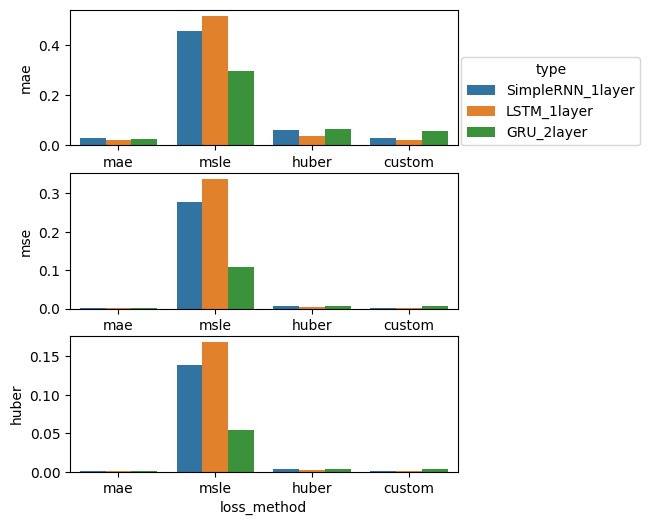

In [40]:
fig = plt.figure(figsize=(5,6))
axs = fig.subplots(nrows=3)
for i, col in enumerate(['mae', 'mse', 'huber']):
    if i == 0:
        sns.move_legend(sns.barplot(res, hue='type', y=col, x='loss_method', ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res, hue='type', y=col, x='loss_method', ax=axs[i], legend=False)

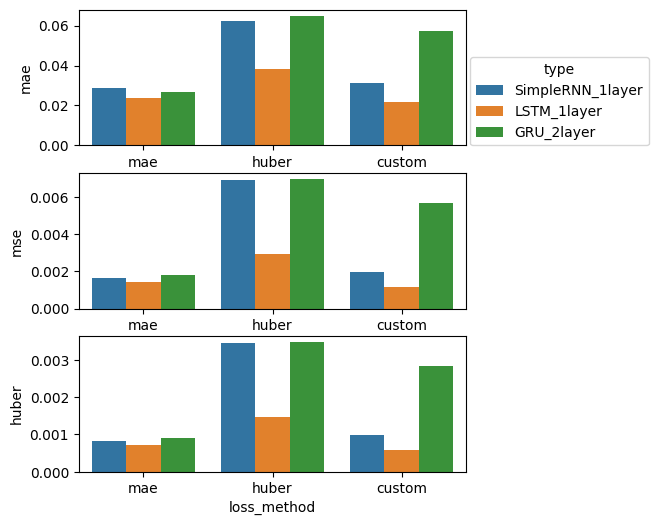

In [41]:
fig = plt.figure(figsize=(5,6))
axs = fig.subplots(nrows=3)
res2 = res[res.loss_method != 'msle']
for i, col in enumerate(['mae', 'mse', 'huber']):
    if i == 0:
        sns.move_legend(sns.barplot(res2, hue='type', y=col, x='loss_method', ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res2, hue='type', y=col, x='loss_method', ax=axs[i], legend=False)

LSTM sa custom funkcijom je dobio najbolje rezultate.

Medjutim MAE je u globali dao najbolje rezultate, tako da se on koristi nadalje.